# Importar librerias

In [36]:
c = 7 # Valor para variables climaticas

In [37]:
import time
start = time.time()
#importar datos y librerias

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from scipy import signal
from scipy import special
from scipy.ndimage.interpolation import shift
from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
%matplotlib inline

In [38]:
# Plotly
import chart_studio.plotly as ply
import cufflinks as cf
cf.go_offline()

# Funciones

In [39]:
# para calcular el mape
def Mape(y,y_pred):
    return np.mean(np.abs((y-y_pred)/y))*100

# para hacer kronecker por fila
def kronecker(data1:'Dataframe 1',data2:'Dataframe 2'):
    Combinacion = pd.DataFrame(); d1 = pd.DataFrame()
    for i in data2.columns:
        d1 = data1.multiply(data2[f"{i}"] , axis="index")
        d1.columns = [f'{i}_{j}' for j in data1.columns]
        Combinacion = pd.concat([Combinacion, d1], axis = 1)
    return Combinacion

# para crear variables difusas
def triangular():
    # Se crea x
    ma = pd.DataFrame();
    x = consumofeb.index.dayofyear.tolist()
    # Se crean variables a, b y c
    height = difs()
    for hei in height:
        ba = pd.DataFrame(x, columns=["x"])
        ba["a"] = height[hei][0]
        ba["b"] = height[hei][1]
        ba["c"] = height[hei][2]
        # Variable difusa
        ca = pd.DataFrame()
        ca["bo"] = (ba.x-ba.a)/(ba.b-ba.a)
        ca["ba"] = (ba.c-ba.x)/(ba.c-ba.b)
        ca = ca.min(axis = 1)
        ca[ca<0]=0
        ma = pd.concat([ma, ca], axis = 1) # Se concatenan
        
    ma.index = consumofeb.index
    ma.columns = height.keys()
    return ma

In [40]:
def calor():
    # Inicializar posicion de datos variables difusas

    calor1 = [9, 151, 365.25+9]
    calor2 = [9-365.25, 151-365.25, 9]
    frio1 = [151-365.25, 9, 151]
    frio2 = [151, 365.25+9, 365.25+365.25]

    height = {'calor1': calor1, 'calor2': calor2, 'frio1': frio1, 'frio2': frio2} 
    return height

# para crear variables difusas
def triangular1():
    
    # Se crea x
    ma = pd.DataFrame();
    x = consumofeb.index.dayofyear.to_list()
    # Se crean variables a, b y c
    height = calor()
    for hei in height:
        ba = pd.DataFrame(x, columns=["x"])
        ba["a"] = height[hei][0]
        ba["b"] = height[hei][1]
        ba["c"] = height[hei][2]
        # Variable difusa
        ca = pd.DataFrame()
        ca["bo"] = (ba.x-ba.a)/(ba.b-ba.a)
        ca["ba"] = (ba.c-ba.x)/(ba.c-ba.b)
        ca = ca.min(axis = 1)
        ca[ca<0]=0
        ma = pd.concat([ma, ca], axis = 1) # Se concatenan

    ma.index = consumofeb.index
    ma.columns = height.keys()
    return ma

# Cargar datos

In [41]:
def cargar():
    # variables climaticas
    consumofeb=pd.read_excel(r'Data//Consumo_feb.xlsx').set_index("fecha").loc["2007-01-01":"2020-03-30"] # desde el 2007
    consumofeb=consumofeb.drop(["prom","Lluvia","Velocidad_viento"],1) # variables no importantes para el modelo
    #variables de consumo MWh
    consumo=pd.read_excel(r'Data//Data1.xlsx').set_index("fecha").loc["2007-01-01":"2020-03-30"]  # consumo de energia en MWh
    while True:
        if len(consumofeb.index) != len(consumo.index): 
            raise RuntimeError("Climatic variable and consumption variable length does not match")
            break
        else: return consumo, consumofeb

consumo, consumofeb = cargar()

In [42]:
if len(consumofeb.index) == len(consumo.index): print("ok")

ok


 # Variables difusas

In [43]:
def difs():
    # Inicializar posicion de datos variables difusas

    inv1 = [310.5-365.25, 8.6529, 138.941176470588]
    pr = [8.6529, 138.941176470588, 221.9375]
    vr = [138.941176470588, 221.9375, 310.5]
    ot = [221.9375, 310.5, 365.25+8.6529]
    ot2 = [221.9375-365.25, 310.5-365.25, 8.6529]
    inv2 = [310.5, 365.25+8.6529, 365.25+138.941176470588]

    height = {'Invierno1': inv1,'Primavera': pr,'verano': vr,'Otoño': ot,'Otoño2': ot2,'Invierno2': inv2,} 
    return height 

-  Para graficar

In [44]:
triangular().iplot()

In [45]:
triangular1().iplot()

# Variables climaticas

In [46]:
def pba(j, n):
    # armonicos
    f, asd = signal.periodogram(consumofeb[j], 1)
#     plt.figure()
#     plt.plot(1/f, asd)
    picos = pd.DataFrame(asd, 1/(f), columns=["potencia"])
    picos = picos.sort_values(by="potencia",ascending=False).reset_index().head(12)
    picos.columns = ["periodo", "potencia"]
    #fourier
    sencos = pd.DataFrame(index = consumofeb.index)
    t = np.arange(1,len(consumofeb)+1)
    sencos["t"]=t
    for i  in  picos.periodo:
            sencos[f"{i:.2f}_sen"] = np.abs(np.sin(((2*np.pi)/(i))*t))
            sencos[f"{i:.2f}_cos"] = np.abs(np.cos(((2*np.pi)/(i))*t))
    sencos['ones']=1
    sencos['sen1']=np.abs(np.sin(((2*np.pi)/(365.25))*t))
    sencos['cos1']=np.abs(np.cos(((2*np.pi)/(365.25))*t))
    
    triangular_ = pd.concat([triangular(), triangular1()], axis = 1)
    sencos=kronecker(sencos, triangular_)
    #regresion
    X_train, X_test, y_train, y_test = train_test_split(sencos, consumofeb[j], test_size=n, shuffle = False)
    
    reg = LinearRegression(n_jobs=-1).fit(X_train, y_train)
    y_predict=reg.predict(X_test)
    
    nov=pd.DataFrame(np.concatenate([reg.predict(X_train),y_predict]),index=consumofeb.index,columns=[f"{j}"])

    return nov

In [47]:
# pba("max", 33)

In [48]:
def modelosclima(n):
    ca = pd.DataFrame(index = consumo.index)
    for i in ["mín", "max", "Nubosidad"]:
        ca = pd.concat([ca, pba(i, n)], axis = 1)
    return ca

In [49]:
# Se corre y guarda en una variable los datos de clima predichos
modclima = modelosclima(c)

In [50]:
temp = consumofeb[consumofeb.index.year > 2015]

In [51]:
temp1 = (temp["max"] + temp["mín"])/2

In [52]:
temp1.max(), temp1.min()

(26.720066291276574, 10.694059040590407)

In [53]:
temp1.describe()

count    1551.000000
mean       20.284976
std         2.707066
min        10.694059
25%        18.418630
50%        20.736863
75%        22.311624
max        26.720066
dtype: float64

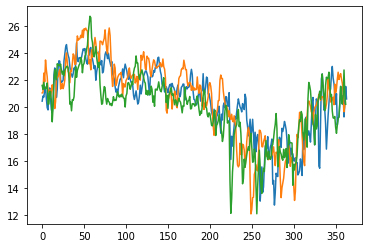

In [54]:
plt.plot(temp1.loc["2019-04-02":"2020-03-30"].values, label = "2019") 
plt.plot(temp1.loc["2017-04-04":"2018-03-31"].values, label = "2019")
plt.plot(temp1.loc["2018-04-03":"2019-03-31"].values, label = "2019")

In [55]:
temp1.iplot()

# Varibles festivos

In [56]:
def festivos():
    festivos=pd.read_excel(r'Data\\Festivos.xlsx')
    festivos2=pd.read_excel(r'Data\\Festivos2.xlsx')

    Dum = pd.DataFrame(index = consumo.index)

    for col in festivos.columns:
        Dum[f"{col}"] = consumo.index.isin(festivos[f"{col}"])
        Dum[col] = Dum[col].replace([False, True],[0, 1])
        clean = Dum[col].values
        Dum[col] = Dum[col]+shift(clean, 1, cval=0)*.4
        Dum[col] = Dum[col]+shift(clean, -1, cval=0)*.4
        Dum[col] = Dum[col]+shift(clean, 2, cval=0)*.1
        Dum[col] = Dum[col]+shift(clean, -2, cval=0)*.1
        Dum[col] = Dum[col]/2

    Dum["ones"] = 1
    Dum["t"]=np.arange(1,len(consumo.index)+1)    
    
    for col in festivos2.columns:
        Dum[col] = consumo.index.isin(festivos2[col])
    Dum = Dum.replace([False, True],[0, 1])
    
    return Dum

# Todas las variables independientes

In [57]:
def dummies(n):   
    # variables eureka y clima
    consumo2 = pd.DataFrame(index=consumo.index)
    consumo2["num"] = np.arange(1,len(consumo.index)+1)
    consumo2["day"] = consumo.index.weekday
    consumo2["eureka1"] = consumo2.day**3
    consumo2["eureka2"] = modclima["max"]*consumo2.num
    consumo2["month"] = consumo.index.month
    X = consumo2.join(modclima)
    # normalizacion eureka-clima
    X_norm = X/X.max()
    
    # variables gplearn
#     X_norm["gplearn1"]=np.cos(X_norm.day)*X_norm.num
#     X_norm["gplearn2"]=X_norm.num*X_norm["mín"]
#     X_norm["gplearn3"]=3.319**X_norm["max"]*np.cos(X_norm.day)
#     X_norm["gplearn8"]=3.319**X_norm["max"]*X_norm.num 
#     X_norm["gplearn4"]=np.cos(X_norm.day)*np.sin(X_norm.day)
#     X_norm["gplearn6"]=X_norm["max"]**2*X_norm["mín"]**2
#     X_norm["gplearn7"]=1/np.cos(X_norm.day)
#     X_norm["gplearn10"]=X_norm["max"]*X_norm["mín"]**3*np.cos(X_norm.month)**2
    # variables dummies
    X_norm = pd.get_dummies(X_norm, columns=["month", "day"], prefix=["month", "day"], drop_first=True)
    
    X_norm=X_norm.drop(["mín", "max", "Nubosidad"],axis=1) 

    # variables festivos y difusa de clima
    X_norm = X_norm.join(festivos())
    triangular_ = pd.concat([triangular(), triangular1()], axis = 1)
    X_norm = X_norm.join(triangular_)
    
    # variables entre y fin
    X_norm["fin"]=consumo.index.weekday
    X_norm["entre"]=consumo.index.weekday
    X_norm["fin"]=X_norm["fin"].replace([0,1,2,3,4,5,6],[.5,0,0,0,.5,1,1])
    X_norm["entre"]=X_norm["entre"].replace([0,1,2,3,4,5,6],[.5,1,1,1,.5,0,0])
    return X_norm

In [58]:
beg = time.time()
dummies(0)
end = time.time()
end - beg

0.7709803581237793

In [59]:
X = dummies(365)

In [60]:
X.to_csv("X.csv")